## Image Embeddings

### Preface

**Summary**
- TBD

**Acknowledgements**
- Dataset: https://www.tensorflow.org/datasets/catalog/tf_flowers
- Blog Article: https://rom1504.medium.com/image-embeddings-ed1b194d113e
- Code Repo: https://github.com/rom1504/image_embeddings
- Code File: https://github.com/rom1504/image_embeddings/blob/master/notebooks/from_scratch.ipynb

### Initialization: Download and Save

**Packages**

In [2]:
import numpy as pkg_num
import os as pkg_os
import time as pkg_time
import math as pkg_math
import warnings as pkg_warnings
import matplotlib.pyplot as pkg_mplot
import matplotlib.image as pkg_mp_image
import pathlib as pkg_pathlib
import shutil as pkg_shutil

In [3]:
# Record Start Time
run_start_time = pkg_time.time()

In [4]:
# Miscellaneous
%matplotlib inline
pkg_warnings.filterwarnings(action="ignore")

# Tensor Flow is optimized for CUDA-GPU
# That error goes away with following setting
# TODO: Figure out why the error goes away with this setting!
pkg_os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [5]:
import pandas as pkg_pandas
import absl.logging as pkg_logging
import IPython.display as pkg_disp
import ipywidgets as pkg_widgets
import PIL as pkg_pil
import PIL.Image as pkg_pil_image
import pyarrow as pkg_arrow
import pyarrow.parquet as pkg_parquet
import tensorflow as pkg_tf
import tensorflow_datasets as pkg_tfds
import tensorflow_datasets.core.dataset_utils as pkg_tfds_utils
import tensorflow_datasets.core.features as pkg_tfds_features
import efficientnet as pkg_effinet
import efficientnet.preprocessing as pkg_effinet_preprocessing
import efficientnet.tfkeras as pkg_tfkeras
from efficientnet.tfkeras import EfficientNetB6 as EfficientNetRef
import faiss as pkg_faiss

2022-08-22 23:08:36.138478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 23:08:36.138523: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


**Common**

In [6]:
# Performance related settings
AUTOTUNE = pkg_tf.data.AUTOTUNE

# Image Size (Target)
image_height = 180
image_width = 180
image_size = (image_height, image_width)

# Batch Size
batch_size = 32

# Path stuff
repo_root_dirpath = pkg_pathlib.Path.cwd().parent
temp_root_dirpath = repo_root_dirpath.joinpath(".outputs")
temp_flowers_ds_dirpath = temp_root_dirpath.joinpath(".datasets/tf_flowers")

folder_name_downloads = "downloads"
temp_downloads_dirpath = temp_flowers_ds_dirpath.joinpath(folder_name_downloads)

folder_name_images = "images"
temp_images_dirpath = temp_flowers_ds_dirpath.joinpath(folder_name_images)

folder_name_tfrecords = "tfrecords"
temp_tfrecords_dirpath = temp_flowers_ds_dirpath.joinpath(folder_name_tfrecords)

folder_name_embeddings = "embeddings"
temp_embeddings_dirpath = temp_flowers_ds_dirpath.joinpath(folder_name_embeddings)

temp_dirpaths = {
    folder_name_downloads: temp_downloads_dirpath,
    folder_name_images : temp_images_dirpath,
    folder_name_tfrecords: temp_tfrecords_dirpath,
    folder_name_embeddings : temp_embeddings_dirpath
}

In [7]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [8]:
def configure_for_batch_performance(ds):
  ds = configure_for_performance(ds)
  ds = ds.batch(batch_size=batch_size)
  return ds

In [9]:
def create_dirpath(dirpath):
    # Create the data directory
    dirpath.mkdir(parents=True, exist_ok=True)
    return dirpath

In [10]:
def recreate_dirpath(dirpath):
    # (Re)create the data directory
    pkg_shutil.rmtree(dirpath, ignore_errors=True)
    dirpath.mkdir(parents=True, exist_ok=False)
    return dirpath

In [11]:
def recreate_folder(folder_name):
    return recreate_dirpath(temp_dirpaths[folder_name])

In [12]:
def print_folder_stats(folder_name):
    checkpoint_time = int(pkg_time.time() - run_start_time)
    print("Directory Stats ({}), at {} seconds: {}".format(\
        folder_name, checkpoint_time, temp_dirpaths[folder_name].stat()))


**Load Data**

In [13]:
def download_dataset(dataset_name, data_dirpath):
    ds, ds_info = pkg_tfds.load(name=dataset_name, data_dir=data_dirpath, 
        split='train', with_info=True)
    return ds, ds_info

def save_examples(ds, ds_info, data_dirpath, num_examples = 10, image_key=None):
  """Save images from an image classification dataset.

  Only works with datasets that have 1 image feature and optionally 1 label
  feature (both inferred from `ds_info`). Note the dataset should be unbatched.

  Usage:

  ```python
  ds, ds_info = tfds.load('cifar10', split='train', with_info=True)
  fig = save_examples(ds, ds_info, data_dir)
  ```

  Args:
    ds: `tf.data.Dataset`. The tf.data.Dataset object to visualize. Examples
      should not be batched.
    num_examples: `int`. Number of examples to save
    ds_info: The dataset info object to which extract the label and features
      info. Available either through `tfds.load('mnist', with_info=True)` or
      `tfds.builder('mnist').info`
    data_dir: `pathlib.Path`. Where to save images
    image_key: `string`, name of the feature that contains the image. If not
       set, the system will try to auto-detect it.

  Returns:
  """

  if not image_key:
    # Infer the image and label keys
    image_keys = [
        k for k, feature in ds_info.features.items()
        if isinstance(feature, pkg_tfds_features.Image)
    ]

    if not image_keys:
      raise ValueError(
          "Visualisation not supported for dataset `{}`. Was not able to "
          "auto-infer image.".format(ds_info.name))

    if len(image_keys) > 1:
      raise ValueError(
          "Multiple image features detected in the dataset. Using the first one. You can "
          "use `image_key` argument to override. Images detected: %s" %
          (",".join(image_keys)))

    image_key = image_keys[0]

  label_keys = [
      k for k, feature in ds_info.features.items()
      if isinstance(feature, pkg_tfds_features.ClassLabel)
  ]

  label_key = label_keys[0] if len(label_keys) == 1 else None
  if not label_key:
    pkg_logging.info("Was not able to auto-infer label.")

  examples = list(pkg_tfds_utils.as_numpy(ds.take(num_examples)))
  
  # Save the images as files on disk
  for i, ex in enumerate(examples):
    if not isinstance(ex, dict):
      raise ValueError(
          "tensorflow_datasets.show_examples requires examples as `dict`, with the same "
          "structure as `ds_info.features`. It is currently not compatible "
          "with `as_supervised=True`. Received: {}".format(type(ex)))

    # Plot the image
    image = ex[image_key]
    if len(image.shape) != 3:
      raise ValueError(
          "Image dimension should be 3. tensorflow_datasets.show_examples does not support "
          "batched examples or video.")
    _, _, c = image.shape
    if c == 1:
      image = image.reshape(image.shape[:2])
    image = pkg_effinet_preprocessing.center_crop_and_resize(image, 224).astype(pkg_num.uint8)
    im = pkg_pil_image.fromarray(image)
    # Plot the label
    if label_key:
      label = ex[label_key]
      label_str = ds_info.features[label_key].int2str(label)
    else:
      label_str = ""
    filepath = data_dirpath.joinpath("image_{:04d}_{}.jpeg".format(i, label_str))
    im.save(filepath)

In [14]:
def download_and_save_flowers_dataset(example_count):
    create_dirpath(temp_downloads_dirpath)
    ds, ds_info = download_dataset("tf_flowers", temp_downloads_dirpath)
    print_folder_stats(folder_name_downloads)

    recreate_dirpath(temp_images_dirpath)
    save_examples(ds, ds_info, temp_images_dirpath, example_count)
    print_folder_stats(folder_name_images)

    ds = configure_for_performance(ds)
    fig = pkg_tfds.show_examples(ds, ds_info)
    return ds, ds_info

### Transform: Calculate Embeddings

**Routines**

In [15]:
def list_files(folder_name, pattern="*", shuffle=False):
    dirpath = temp_dirpaths[folder_name].as_posix()
    return pkg_tf.data.Dataset.list_files(dirpath + "/" + pattern, shuffle=shuffle)

def process_path(file_path):
    parts = pkg_tf.strings.split(file_path, '/')
    image_name = pkg_tf.strings.split(parts[-1], '.')[0]
    raw = pkg_tf.io.read_file(file_path)
    return raw, image_name


def read_data_from_files(list_ds):
    return list_ds.map(process_path,
        num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE)#.apply(pkg_tf.data.experimental.ignore_errors())


def images_to_embeddings(model, dataset, batch_size):
    return model.predict(dataset.batch(batch_size).map(lambda image_raw, image_name: image_raw), verbose=1)


def save_embeddings_ds_to_parquet(embeddings, dataset, path):
    embeddings = pkg_arrow.array(embeddings.tolist(), type=pkg_arrow.list_(pkg_arrow.float32()))
    image_names = pkg_arrow.array(dataset.map(lambda image_raw, image_name: image_name).as_numpy_iterator())
    table = pkg_arrow.Table.from_arrays([image_names, embeddings], ["image_name", "embedding"])
    pkg_parquet.write_table(table, path)


def compute_save_embeddings(input_folder_name, output_folder_name, num_shards, model, batch_size):
    start = pkg_time.time()
    list_ds = list_files(input_folder_name, "*.jpeg").cache()

    output_dirpath = temp_dirpaths[output_folder_name]
    for shard_id in range(0, num_shards):
        shard_list = list_ds.shard(num_shards=num_shards, index=shard_id)
        shard = read_data_from_files(shard_list)
        embeddings = images_to_embeddings(model, shard, batch_size)
        print("Shard " + str(shard_id) + " done after " + str(int(pkg_time.time() - start)) + "s")
        output_filepath = output_dirpath.joinpath("part-{:04d}.parquet".format(shard_id))
        save_embeddings_ds_to_parquet(embeddings, shard, output_filepath)
        print("Shard " + str(shard_id) + " saved after " + str(int(pkg_time.time() - start)) + "s")
    print("Total time : " + str(int(pkg_time.time() - start)))


def infer_images(input_folder_name, output_folder_name, num_shards=100, batch_size=1000):
    model = EfficientNetRef(weights='imagenet', include_top=False, pooling="avg")
    compute_save_embeddings(input_folder_name, output_folder_name, num_shards, model, batch_size)

In [16]:
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return pkg_tf.train.Feature(int64_list=pkg_tf.train.Int64List(value=[value]))


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(pkg_tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return pkg_tf.train.Feature(bytes_list=pkg_tf.train.BytesList(value=[value]))


def serialize_example(image, image_name):
    feature = {
        'image_name': _bytes_feature(image_name),
        'image_data': _bytes_feature(image)
    }

    example_proto = pkg_tf.train.Example(features=pkg_tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def tf_serialize_example(image, image_name):
    tf_string = pkg_tf.py_function(
        serialize_example,
        (image, image_name),
        pkg_tf.string)
    return pkg_tf.reshape(tf_string, ())


def process_path(file_path):
    parts = pkg_tf.strings.split(file_path, '/')
    image_name = pkg_tf.strings.split(parts[-1], '.')[0]
    raw = pkg_tf.io.read_file(file_path)
    return raw, image_name


def read_image_file_write_tfrecord(files_ds, output_filepath):
    image_ds = files_ds.map(process_path, num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE)
    serialized_features_dataset = image_ds.map(tf_serialize_example, num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE)
    writer = pkg_tf.data.experimental.TFRecordWriter(output_filepath.as_posix())
    writer.write(serialized_features_dataset)


def image_files_to_tfrecords(image_folder_name, output_folder_name, num_shard):
    list_ds = list_files(image_folder_name, "*.jpeg")
    output_dirpath = temp_dirpaths[output_folder_name]
    start = pkg_time.time()
    for shard_id in range(0, num_shard):
        shard_list = list_ds.shard(num_shards=num_shard, index=shard_id)
        output_filepath = output_dirpath.joinpath("part-{:04d}.tfrecord".format(shard_id))
        read_image_file_write_tfrecord(shard_list, output_filepath)
        print("Shard " + str(shard_id) + " saved after " + str(int(pkg_time.time() - start)) + "s")


def _parse_function(example_proto):
    feature_description = {
        'image_name': pkg_tf.io.FixedLenFeature([], pkg_tf.string),
        'image_data': pkg_tf.io.FixedLenFeature([], pkg_tf.string)
    }
    return pkg_tf.io.parse_single_example(example_proto, feature_description)


def preprocess_image(d):
    image_name = d['image_name']
    raw = d['image_data']
    image = pkg_tf.image.decode_jpeg(raw)
    image = pkg_tf.image.convert_image_dtype(image, pkg_tf.float32)

    return image, image_name


def read_tfrecord(filepath):
    raw_dataset =  pkg_tf.data.TFRecordDataset(filenames=[filepath])
    return raw_dataset \
        .map(_parse_function, num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE) \
        .map(preprocess_image, num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE) \
        .apply(pkg_tf.data.experimental.ignore_errors())


def tfrecords_to_embeddings(input_folder_name, output_folder_name, model, batch_size):
    tfrecords = [f.numpy().decode("utf-8") for f in list_files(input_folder_name, "*.tfrecord")]
    start = pkg_time.time()
    output_dirpath = temp_dirpaths[output_folder_name]
    for shard_id, tfrecord in enumerate(tfrecords):
        shard = read_tfrecord(tfrecord)
        embeddings = images_to_embeddings(model, shard, batch_size)
        print("Shard " + str(shard_id) + " done after " + str(int(pkg_time.time() - start)) + "s")
        output_filepath = output_dirpath.joinpath("part-{:04d}.parquet".format(shard_id))
        save_embeddings_ds_to_parquet(embeddings, shard, output_filepath)
        print("Shard " + str(shard_id) + " saved after " + str(int(pkg_time.time() - start)) + "s")

**Models**

In [17]:
def calculate_and_save_embeddings_flowers_dataset(shard_count):
    recreate_folder(folder_name_tfrecords)
    image_files_to_tfrecords(folder_name_images, folder_name_tfrecords, shard_count)
    print_folder_stats(folder_name_tfrecords)

    recreate_folder(folder_name_embeddings)
    model = EfficientNetRef(weights='imagenet', include_top=False, pooling="avg")
    tfrecords_to_embeddings(folder_name_tfrecords, folder_name_embeddings, model, batch_size)
    print_folder_stats(folder_name_embeddings)


### Search

**Display**

In [18]:
def get_image_filepath(image_name):
  return temp_images_dirpath.joinpath(image_name+".jpeg")

def display_picture(image_name):
  image_filepath = get_image_filepath(image_name)
  print("\nQuery Image: ", image_name)
  pkg_disp.display(pkg_disp.Image(filename=image_filepath))

def display_results(results):
  hbox = pkg_widgets.HBox([pkg_widgets.VBox([
    pkg_widgets.widgets.Label(f"{distance:.2f} {image_name}"),
    pkg_widgets.widgets.Image(value=open(get_image_filepath(image_name), 'rb').read())
  ]) for distance, image_name in results])
  print("\nQuery Resut Images: ")
  pkg_disp.display(hbox)

**Load Data**

In [19]:
def load_embeddings_into_dataframe(folder_name):
    file_list = [f.numpy().decode("utf-8") for f in list_files(folder_name, "*.parquet")]
    all_df = None
    for file_path in file_list:
        shard_df = pkg_parquet.read_table(file_path).to_pandas()
        if (all_df is None): 
            all_df = shard_df
        else:
            all_df = pkg_pandas.concat([all_df, shard_df])
    return all_df

def populate_index(embeds):
    # TODO: What is special about this number 1280?
    # NOTE: This is not same as no. of features in embedding (i.e. embeds.shape[1])
    num_dimensions = embeds.shape[1]
    index = pkg_faiss.IndexFlatIP(num_dimensions)
    index.add(embeds)
    return index

def build_maps(df):
    id_to_name = {k:v.decode("utf-8") for k,v in enumerate(list(df["image_name"]))}
    name_to_id = {v:k for k,v in id_to_name.items()}
    return id_to_name, name_to_id

def build_search_index():
    embed_df = load_embeddings_into_dataframe(folder_name=folder_name_embeddings)
    #print(embed_df.head())

    embeds = pkg_num.stack(embed_df["embedding"].to_numpy())
    print("Shapes: DataFrame = {}, Embeddings = {}".format(embed_df.shape, embeds.shape))

    id_map, name_map = build_maps(embed_df)
    print("Map Sizes: id_map = {}, name_map = {}".format(len(id_map), len(name_map)))

    index = populate_index(embeds)  
    return index, embeds, id_map, name_map

**Find**

In [20]:
def search_images(index, embeds, id_map, query_id, k=5):
  dim, id_list = index.search(pkg_num.expand_dims(embeds[query_id], 0), k)
  return list(zip(dim[0], [id_map[x] for x in id_list[0]]))

In [21]:
def search_and_display(index, embeds, id_map, query_id):
  image_name = id_map[query_id]
  display_picture(image_name)
  display_results(search_images(index, embeds, id_map, query_id))

### Main

**Process**

In [22]:
target_example_count = 2000
target_shard_count = 10

# NOTE: Uncomment the below on a fresh machine
# NOTE: MUST comment this whenever the target-config is revised
# Once downloaded and saved, comment it back
# Once downloaded and save, we can reuse the same for all the future runs
#download_and_save_flowers_dataset(example_count=target_example_count)

# NOTE: Uncomment the below for (re)clculation of embeddings
# NOTE: MUST uncomment this whenever any of the above are uncommented
# Once embeddings are calculated, comment it back
# Once embeddings are calculated for a selected model, we can reuse the same for all the future runs 
#calculate_and_save_embeddings_flowers_dataset(shard_count=target_shard_count)

In [23]:
index, embeds, id_map, name_map = build_search_index()

Shapes: DataFrame = (2000, 2), Embeddings = (2000, 2304)
Map Sizes: id_map = 2000, name_map = 2000


2022-08-22 23:08:39.923647: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-22 23:08:39.923737: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-22 23:08:39.923780: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (raooruga-WX-1): /proc/driver/nvidia/version does not exist
2022-08-22 23:08:39.924156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Query Image:  image_0070_dandelion


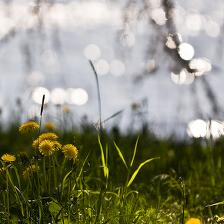


Query Resut Images: 



Query Image:  image_0190_daisy


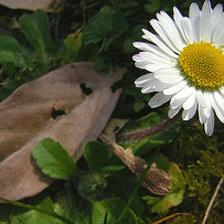


Query Resut Images: 



Query Image:  image_0310_daisy


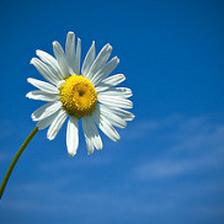


Query Resut Images: 



Query Image:  image_0470_daisy


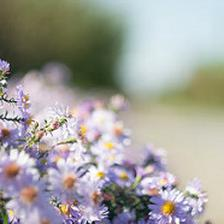


Query Resut Images: 



Query Image:  image_0670_sunflowers


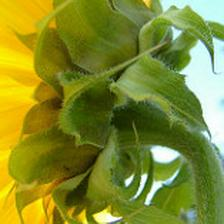


Query Resut Images: 


In [24]:
for image_id in [7, 19, 31, 47, 67]:
    search_and_display(index, embeds, id_map, image_id)


Query Image:  image_1070_roses


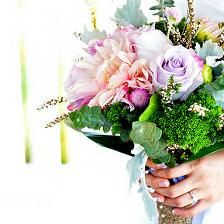


Query Resut Images: 



Query Image:  image_1190_tulips


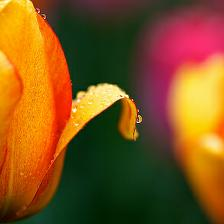


Query Resut Images: 



Query Image:  image_1310_roses


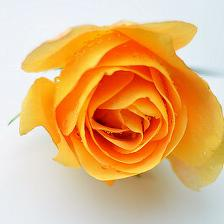


Query Resut Images: 



Query Image:  image_1470_roses


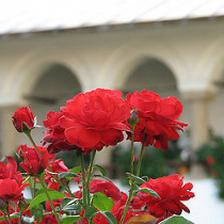


Query Resut Images: 



Query Image:  image_1670_dandelion


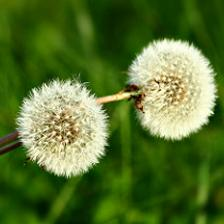


Query Resut Images: 


In [25]:
for image_id in [107, 119, 131, 147, 167]:
    search_and_display(index, embeds, id_map, image_id)


Query Image:  image_1081_daisy


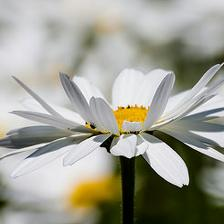


Query Resut Images: 



Query Image:  image_1201_dandelion


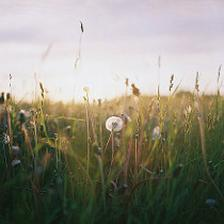


Query Resut Images: 



Query Image:  image_1321_roses


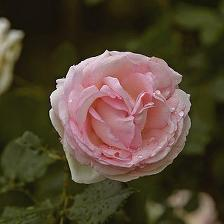


Query Resut Images: 



Query Image:  image_1481_daisy


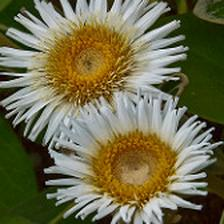


Query Resut Images: 



Query Image:  image_1681_dandelion


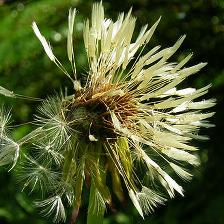


Query Resut Images: 


In [26]:
for image_id in [308, 320, 332, 348, 368]:
    search_and_display(index, embeds, id_map, image_id)

In [27]:
# Compute Total Run Time
run_time_seconds = int(pkg_time.time() - run_start_time)
print("Total Run Time: {} seconds".format(run_time_seconds))

Total Run Time: 8 seconds
